## Predict Model

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import pandas as pd
from PIL import Image
from google.colab import files
from tensorflow.keras.models import load_model
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

# ==========================================
# 1. CONFIGURACIÓN Y PARÁMETROS
# ==========================================
# Asegúrate de que estos valores sean idénticos a los del entrenamiento
IMG_WIDTH, IMG_HEIGHT = 128, 128  # Ajusta según tu entrenamiento
FINAL_MODEL_FILENAME = f"simpsons_model_{IMG_WIDTH}.keras" # Nombre de tu modelo
GOOGLE_DRIVE_FOLDER_ID = '1GZ0NBMKvCcNAvPdW50j6OwcSasaoK8A1'
PRE_PROCESSED_DATASET = 'simpsons_pre_processed_data.npz'

# ==========================================
# 2. FUNCIONES DE CARGA (DRIVE)
# ==========================================
def get_drive_service():
    from google.colab import auth
    auth.authenticate_user()
    return build('drive', 'v3')

drive_service = get_drive_service()

def download_from_drive(file_name, folder_id):
    query = f"name = '{file_name}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])
    if not items:
        print(f"Error: {file_name} no encontrado.")
        return False

    file_id = items[0]['id']
    request = drive_service.files().get_media(fileId=file_id)
    with io.FileIO(file_name, 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
    print(f"✅ {file_name} descargado correctamente.")
    return True

# ==========================================
# 3. PREPARACIÓN DE CLASES (Consistencia con entrenamiento)
# ==========================================
def get_consistent_class_names():
    # Descargar y cargar dataset para obtener nombres originales
    download_from_drive(PRE_PROCESSED_DATASET, GOOGLE_DRIVE_FOLDER_ID)
    data = np.load(PRE_PROCESSED_DATASET, allow_pickle=True)
    print("Llaves encontradas en el archivo:", data.files)
    y_full = data['y']
    class_names = data['labels']

    # Aplicar el MISMO filtro que en el entrenamiento (MIN_SAMPLES_THRESHOLD = 5)
    unique_classes, counts = np.unique(y_full, return_counts=True)
    rare_classes_ids = unique_classes[counts < 5]

    # Filtrar la lista de nombres para que coincida con la salida de la neurona Softmax
    rare_classes_set = set(rare_classes_ids)
    final_class_names = [name for i, name in enumerate(class_names) if i not in rare_classes_set]

    print(f"Total clases detectadas para predicción: {len(final_class_names)}")
    return final_class_names

# ==========================================
# 4. PROCESAMIENTO DE IMAGEN Y PREDICCIÓN
# ==========================================
def preprocess_uploaded_image(image_path):
    """Aplica redimensión y normalización /255.0"""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img).astype('float32') / 255.0
    return img_array

def predict_and_visualize(model, image_array, class_names, real_label_name=None):
    # Añadir dimensión de batch (1, H, W, 3)
    img_batch = np.expand_dims(image_array, axis=0)

    # Predecir
    predictions = model.predict(img_batch, verbose=0)[0]

    # Obtener Top 10
    top_indices = predictions.argsort()[-10:][::-1]
    top_labels = [class_names[i] for i in top_indices]
    top_probs = [predictions[i] for i in top_indices]

    predicted_idx = np.argmax(predictions)
    predicted_label = class_names[predicted_idx]

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # --- LADO IZQUIERDO: IMAGEN ---
    ax1.imshow(image_array)

    # Lógica de color (Verde si acierta, Rojo si falla o Negro si no hay etiqueta real)
    is_correct = False
    title_color = 'black'

    if real_label_name:
        is_correct = str(real_label_name).strip().lower() == str(predicted_label).strip().lower()
        title_color = 'green' if is_correct else 'red'

    title_text = f"Predicted: {predicted_label} ({predictions[predicted_idx]*100:.1f}%)"
    if real_label_name:
        title_text = f"Actual: {real_label_name}\n{title_text}"

    ax1.set_title(title_text, color=title_color, fontsize=14, fontweight='bold')
    ax1.axis('off')

    # --- LADO DERECHO: GRÁFICO DE BARRAS ---
    colors = ['#2ecc71' if i == 0 else '#34495e' for i in range(len(top_labels))]
    bars = ax2.barh(top_labels, top_probs, color=colors)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1.1)
    ax2.set_title("Top 10 Confidence Scores", fontsize=12)

    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{width*100:.1f}%', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()


### Loading Model

In [64]:
# ==========================================
# 5. EJECUCIÓN PRINCIPAL
# ==========================================

# 1. Cargar todo lo necesario
if download_from_drive(FINAL_MODEL_FILENAME, GOOGLE_DRIVE_FOLDER_ID):
    model = load_model(FINAL_MODEL_FILENAME)
    target_names = get_consistent_class_names()

✅ simpsons_model_128.keras descargado correctamente.
✅ simpsons_pre_processed_data.npz descargado correctamente.
Llaves encontradas en el archivo: ['X', 'y', 'labels']
Total clases detectadas para predicción: 42



--- Sube una imagen de un personaje de los Simpsons ---


Saving images (1).jpg to images (1).jpg


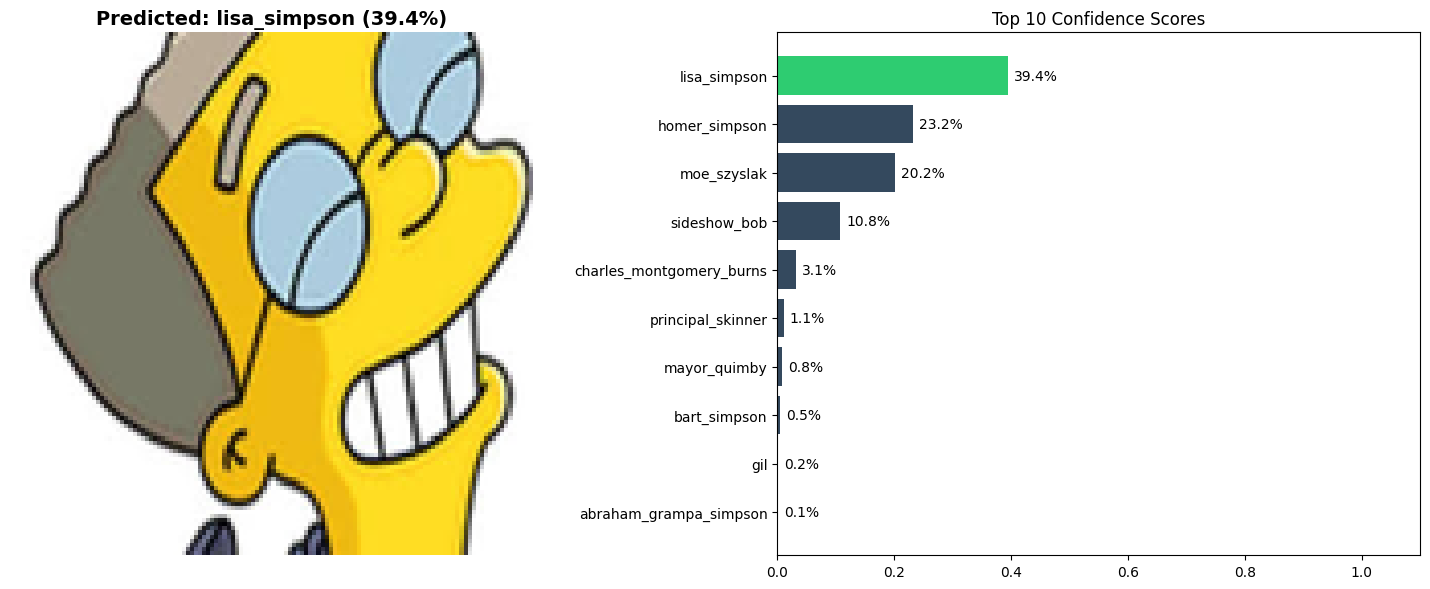

In [94]:
    print("\n--- Sube una imagen de un personaje de los Simpsons ---")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Procesar
        img_processed = preprocess_uploaded_image(filename)

        # Opcional: Si conoces el nombre real para probar el color, ponlo aquí
        # real_name = "Homer Simpson"
        real_name = None

        # Predecir y mostrar
        predict_and_visualize(model, img_processed, target_names, real_label_name=real_name)